In [1]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown


import os
import sys

# if current working directory includes "evaluation" change to parent directory
if "evaluation" in os.getcwd():
    os.chdir("..")
    # Add parent directory to sys.path
    sys.path.append(os.getcwd())



# Verify
print(f"Current working directory: {os.getcwd()}")
print(f"sys.path: {sys.path}")

Current working directory: /root/oxn
sys.path: ['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/root/oxn/venv/lib/python3.11/site-packages', '/root/oxn']


# Evaluation Script
Welcome to the evaluation script. Here, you can interact with results from oxn observability experiments.

To get you started, we have prepared a few experiments:

In [2]:
display_text = ""
for experiments in listdir("experiments"):
   # read first line 
   experiment_disciption = None
   with open(path.join("experiments", experiments)) as f:
      experiment_disciption = f.readline().strip()
      experiment_disciption = experiment_disciption[1:] if experiment_disciption[0] == "#" else ""
   display_text += f" - **{experiments}** : {experiment_disciption} \n"
display(Markdown(display_text))

 - **recommendation_loss15_baseline.yml** :  inject a packet loss of 15% in the recomendation service for 120s with default settings 
 - **recommendation_k8_sampling_5_percent.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_baseline.yml** :  inject a packet delay of 0-90ms in the recomendation service for 120s with default settings 
 - **recommendation_pause_baseline.yml** :  injects a 120s pause in the recomendation service 
 - **recommendation_k8_delay_1m_otel.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_A.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_loss15_B.yml** :  inject packet loss of 15% while increasing sampling rate to 5% 
 - **recommendation_k8_base_1m_otel.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_B.yml** :  inject a packet delay of 0-90ms while increasing sampling rate to 5% 
 - **test.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 
 - **recommendation_loss15_C.yml** :  inject packet loss of 15% while increasing sampling rate to 10% 
 - **recommendation_loss15_A.yml** :  inject packet loss of 15% while increasing the otel metric inverval to 1s 
 - **recommendation_delay90_C.yml** :  inject a packet delay of 0-90ms while increasing sampling rate to 10% 
 - **recommendation_k8_delay_1s_otel.yml** :  inject a packet delay of 0-90ms while increasing the otel metric inverval to 1s 


You can perform any experiment using the following command:

```bash 
oxn experiments/file_from_above --report name_of_your_choice.yaml
```


# Reproduce paper figures and results

To recreate the PacketLoss results of the paper, start with the baseline experiment:
```bash
oxn experiments/recommendation_loss15_baseline.yml --report recommendation_loss15_baseline.yaml
```
then conduct experiments for the three design alternatives:
```bash
oxn experiments/recommendation_loss15_A.yml --report recommendation_loss15_A.yaml
oxn experiments/recommendation_loss15_B.yml --report recommendation_loss15_B.yaml
oxn experiments/recommendation_loss15_C.yml --report recommendation_loss15_C.yaml
```

Each experiment will run for around 10 minutes and once done will create a report which you can then review and interact with using the functions below.

In [3]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation.evaluation as evaluation


importlib.reload(evaluation)

from evaluation.evaluation import Report

assert os.path.exists("reports"), "No reports directory found. Please run the experiments first."

#report = Report.from_file("reports/report_2024-10-07_15-32-55.yaml")


files_in_direcotry = listdir("reports")

# sort them by date
files_in_direcotry.sort(key=lambda x: path.getctime(path.join("reports",x)))

# Load the last experiment
last_experiment = files_in_direcotry[-1]

report_path = path.join("reports", last_experiment.replace(".yaml",".yaml"))
print(report_path)
print(os.getcwd())
report = Report.from_file(report_path)
print(f"Loaded report {last_experiment}")

assert report is not None, "No report found. Please run the experiments first."
assert isinstance(report, Report), "Report is not of type Report"


assert report.interactions is not None, "No interactions found."
assert report.interactions[0] is not None, "No interactions found. "
assert report.interactions[0].response_data is not None, "No data in interaction found"


reports/report_2024-11-18_19-46-28.yaml
/root/oxn
Loaded report report_2024-11-18_19-46-28.yaml


78
[Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=KubernetesProbabilisticHeadSamplingTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyT

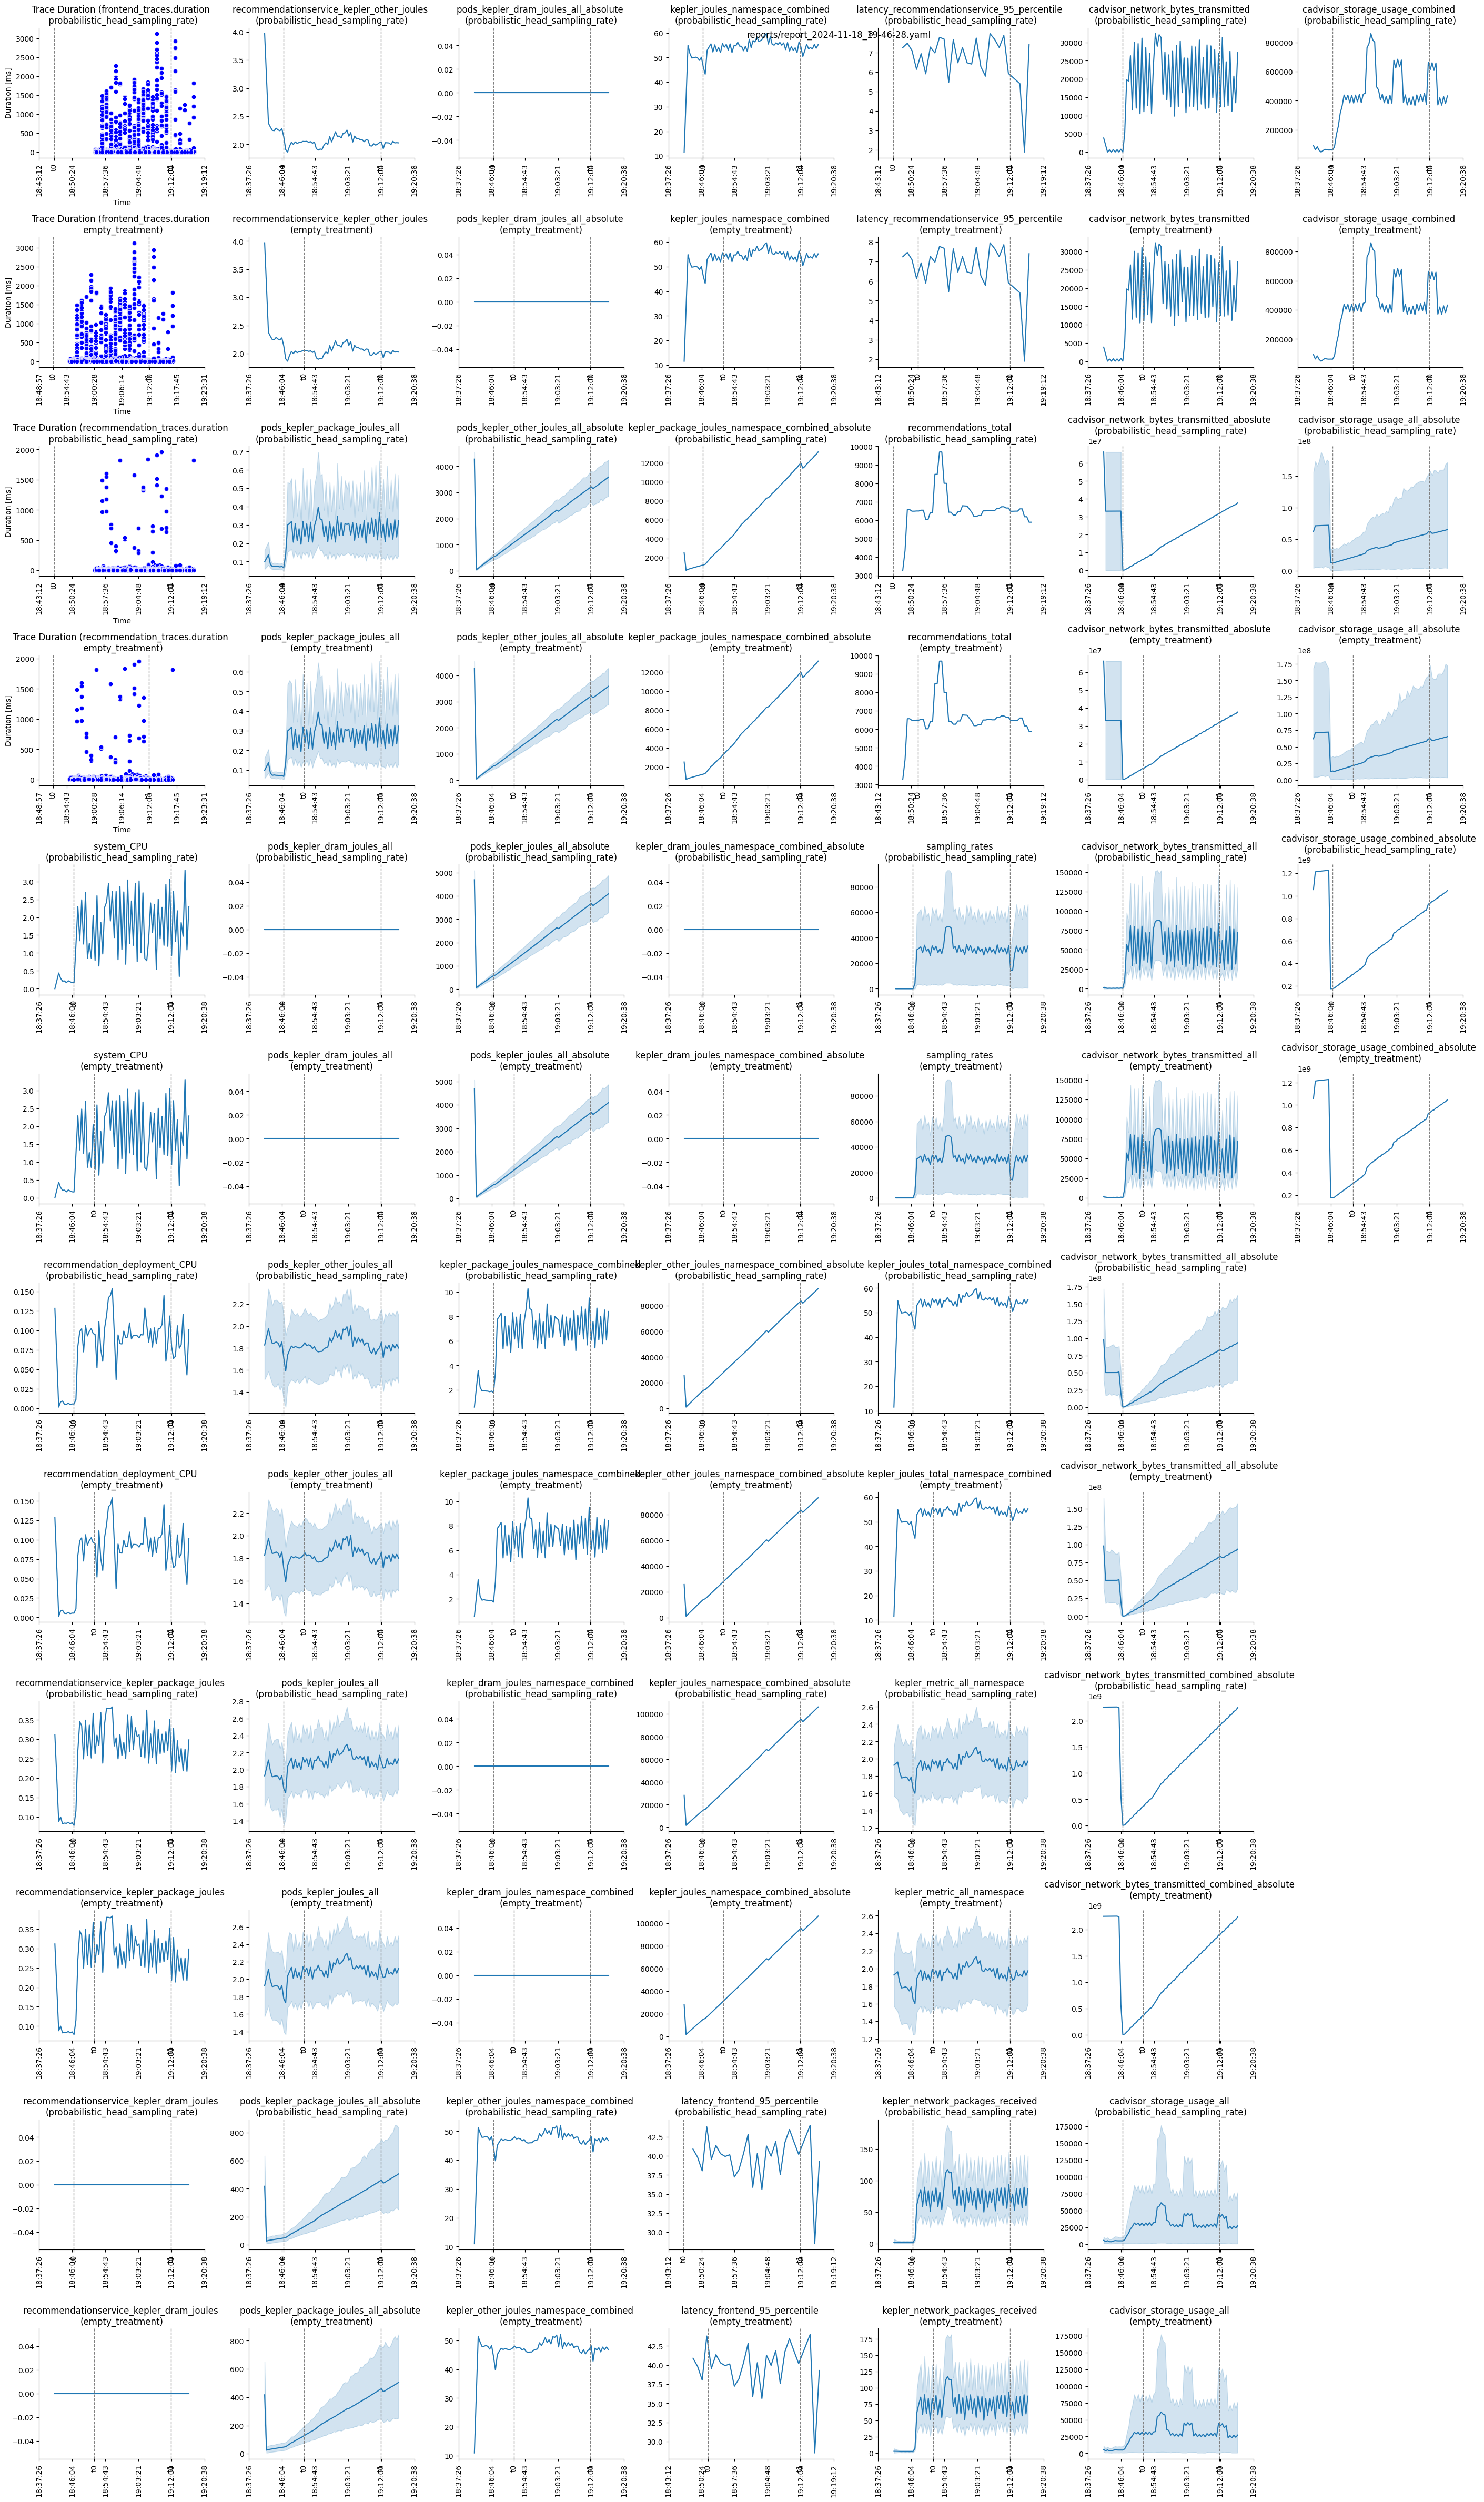

In [7]:
# Plot data for baseline from report
print(len(report.interactions))
print(report.interactions)
# print head
for i in range(len(report.interactions)):
   print("Interaction " + str(i) + " for " + report.interactions[i].treatment_name)
   print(report.interactions[i].response_name)
   print("Data points: " + str(len(report.interactions[i].response_data)))
report.plot_interaction_grid(interactions=range(len(report.interactions)), rows=12, cols=8)


In [8]:
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import ceil
from gevent import monkey
from evaluation import Report

# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# cache the dataframes
cached_dataframes_kepler_pods = []
cached_dataframes_kepler_namespace = []

ImportError: cannot import name 'Report' from 'evaluation' (unknown location)

## Placeholder
----

In [ ]:
# Fault visibility scores for PacketLoss treatment 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='delay_treatment']
visibility

In [11]:
#Import report for design alternative A
report = Report.from_file("reports/report_2024-09-29_16-36-56.yaml")


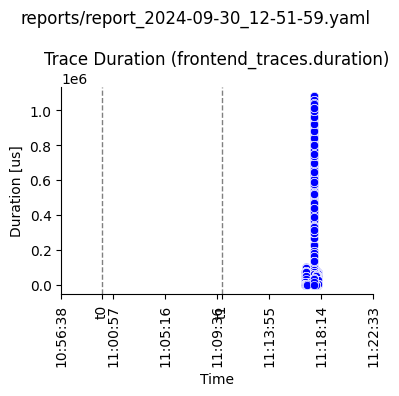

In [17]:
# Plot data for design alternative A
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [18]:
# Fault visibility score for design alternative A 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [19]:
#Import report for design alternative B
report = Report.from_file("recommendation_loss15_B.yaml")


FileNotFoundError: [Errno 2] No such file or directory: 'recommendation_loss15_B.yaml'

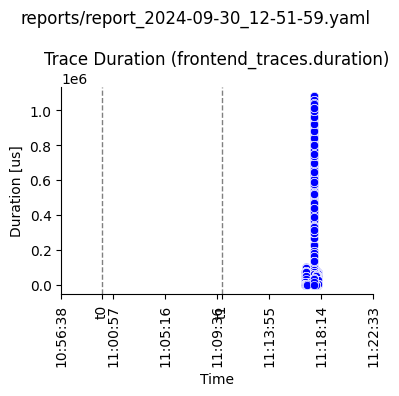

In [20]:
# Plot data for design alternative B
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [39]:
# Fault visibility scores for design alternative B 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_B.yaml,packet_loss_treatment,PacketLossTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.497605
2,recommendation_loss15_B.yaml,packet_loss_treatment,PacketLossTreatment,recommendation_traces.duration,TraceResponseVariable,LR,0.737213


In [40]:
#Import report for design alternative C
report = Report.from_file("recommendation_loss15_C.yaml")

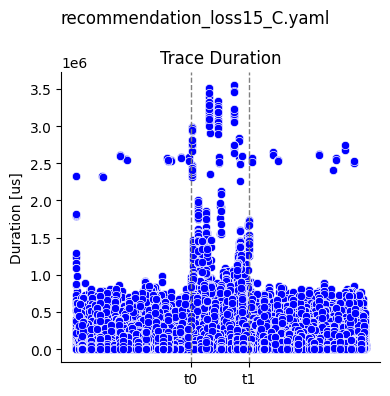

In [41]:
# Plot data for design alternative C
report.plot_interaction_grid(interactions=[0], rows=1, cols=1)

In [42]:
# Fault visibility scores for design alternative C 
visibility = report.get_visibility_df(use_traces=True, folds=2, score="accuracy", split=0.3)
visibility= visibility[visibility['treatment_name']=='packet_loss_treatment']
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[accuracy]
0,recommendation_loss15_C.yaml,packet_loss_treatment,PacketLossTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.404290
2,recommendation_loss15_C.yaml,packet_loss_treatment,PacketLossTreatment,recommendation_traces.duration,TraceResponseVariable,LR,0.796552
